<a href="https://colab.research.google.com/github/matjesg/deepflash2/blob/master/paper/1_gt_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deepflash2 - Ground Truth Estimation

> This notebook reproduces the ground truth estimation results of the deepflash2 [paper](https://arxiv.org/abs/2111.06693).

- **Data**: The data including expert segmentations are available on [Google Drive](https://drive.google.com/drive/folders/1r9AqP9qW9JThbMIvT0jhoA5mPxWEeIjs?usp=sharing). To use the data in Google Colab, create a [shortcut](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop) of the data folder in your personal Google Drive.

*References*:

Griebel, M., Segebarth, D., Stein, N., Schukraft, N., Tovote, P., Blum, R., & Flath, C. M. (2021). Deep-learning in the bioimaging wild: Handling ambiguous data with deepflash2. arXiv preprint arXiv:2111.06693.

Warfield, S. K., Zou, K. H., & Wells, W. M. (2004). Simultaneous truth and performance level estimation (STAPLE): an algorithm for the validation of image segmentation. IEEE transactions on medical imaging, 23(7), 903-921.


## Setup

- Install dependecies
- Connect to drive

In [ ]:
!pip install deepflash2

In [2]:
# Imports
import imageio
import pandas as pd
import numpy as np
from pathlib import Path
from fastprogress import progress_bar
from deepflash2.all import *
from deepflash2.data import _read_msk

In [3]:
# Connect to drive
try:
  from google.colab import drive
  drive.mount('/gdrive')
except:
  print('Google Drive is not available.')

Mounted at /gdrive


## Settings

Choose dataset from `PV_in_HC`,  `cFOS_in_HC`, `mScarlet_in_PAG`,  `YFP_in_CTX`, `GFAP_in_HC`

In [4]:
DATASET = 'cFOS_in_HC'
OUTPUT_PATH = Path("/content/gt_estimation")
DATA_PATH = Path('/gdrive/MyDrive/deepflash2-paper/data')

#https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py
thresholds = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)

cfg=Config(instance_segmentation_metrics=True)

## Ground Truth (GT) Estimation

From the expert annoations on the train and test data...

- Create GT masks via simultaneous truth and performance level estimation (STAPLE) 
- Calculate similarity metrics between experts and estimated GT masks
  - Dice score for instance segmentation
  - Mean average precision for semantic segmentation
- Plot results



Subset: train data
Found 36 unique segmentation mask(s) from 5 expert(s)
Starting ground truth estimation - STAPLE


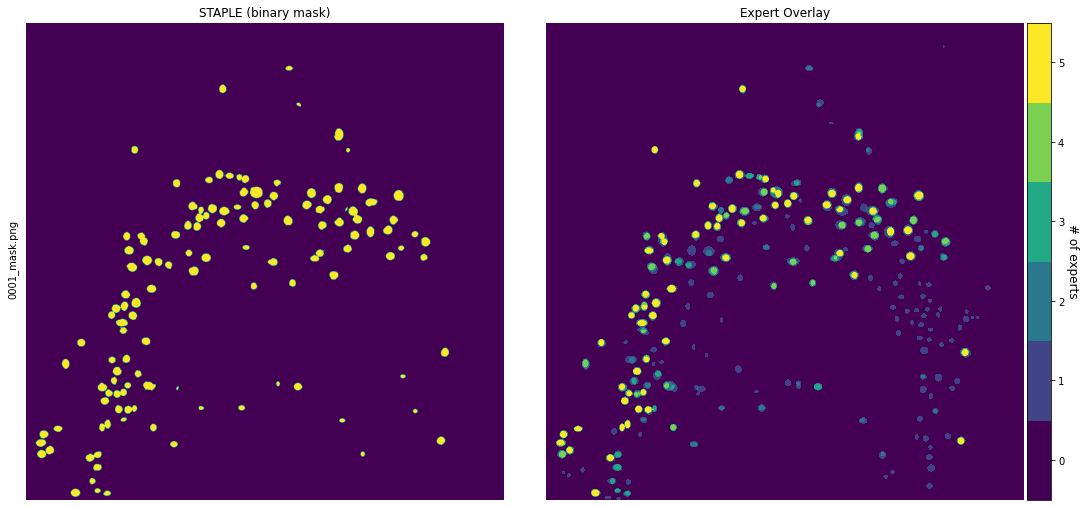

,dice_score,mean_average_precision,average_precision_at_iou_50
1,0.615232,0.209793,0.384615
2,0.854105,0.447582,0.727941
3,0.800831,0.298439,0.638298
4,0.831553,0.330434,0.531034
5,0.701515,0.232453,0.425926
average,0.760647,0.303740,0.541563


---

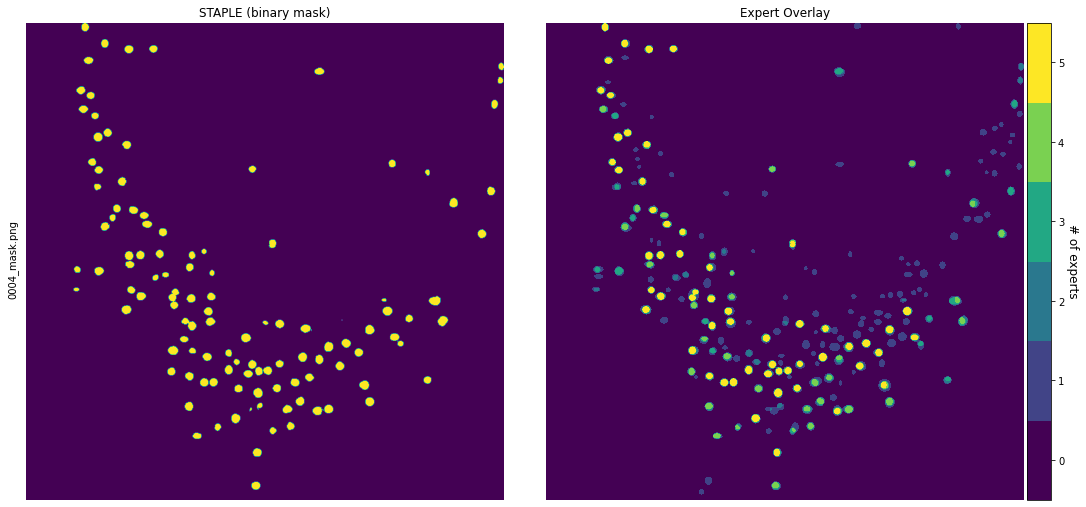

,dice_score,mean_average_precision,average_precision_at_iou_50
1,0.610313,0.258657,0.466667
2,0.822903,0.369849,0.770992
3,0.850710,0.474451,0.782258
4,0.857131,0.499589,0.739837
5,0.682427,0.258915,0.471963
average,0.764697,0.372292,0.646343


---

Subset: test data
Found 8 unique segmentation mask(s) from 5 expert(s)
Starting ground truth estimation - STAPLE


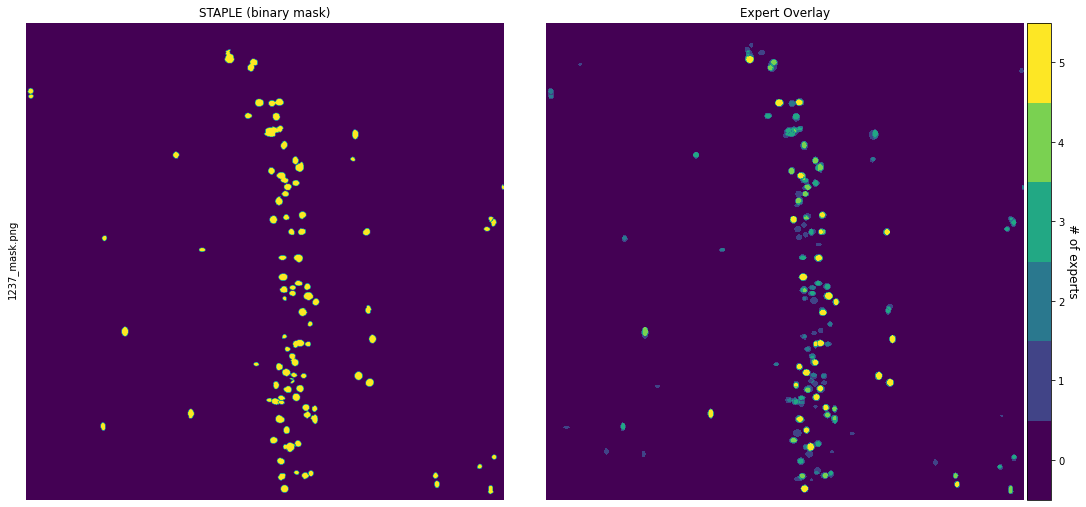

,dice_score,mean_average_precision,average_precision_at_iou_50
1,0.513959,0.188974,0.270833
2,0.821050,0.297811,0.598291
3,0.776737,0.283932,0.614679
4,0.786418,0.281045,0.542857
5,0.725594,0.284046,0.526316
average,0.724752,0.267162,0.510595


---

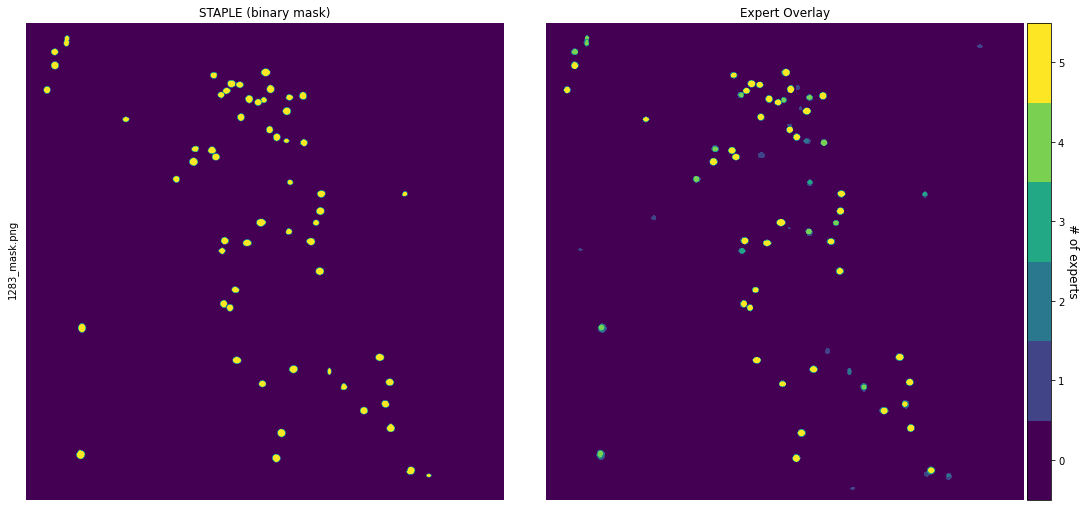

,dice_score,mean_average_precision,average_precision_at_iou_50
1,0.789344,0.487818,0.689655
2,0.861876,0.469481,0.904762
3,0.850746,0.445262,0.791045
4,0.890679,0.549494,0.833333
5,0.897164,0.595375,0.898305
average,0.857962,0.509486,0.823420


---

In [4]:
for subdir in ['train', 'test']:
    print(f'Subset: {subdir} data')
    data_path = DATA_PATH/DATASET/subdir
    save_dir = OUTPUT_PATH/DATASET/subdir/'masks_STAPLE'

    # Load data      
    gt_est = GTEstimator(exp_dir='masks_experts', path=data_path, config=cfg)

    # GT Estimation
    gt_est.gt_estimation(method='STAPLE', save_dir=save_dir)

    # Plot results for the fist two data points                     
    gt_est.show_gt(max_n=2)

## Performance comparison on revised STAPLE results (instance segmentation)

Due to the ambiguities in the data and the expert annotations, GT estimation can yield biologically implausible results (e.g., by merging the areas of two cells). We corrected such artifacts in the instance segmentation datasets PV_in_HC, cFOS_in_HC, mScarlet_in_PAG, YFP_in_CTX (**test set only**).

We therefore recalculate all expert performance metrics on the final GT estimations:


In [5]:
concat_list = []
concat_list_detailed = []

for ds in ['GFAP_in_HC', 'PV_in_HC', 'cFOS_in_HC', 'mScarlet_in_PAG', 'YFP_in_CTX']:

    for subdir in ['test', 'train']:
        if subdir=='test': revised = '' if  ds=='GFAP_in_HC' else '_revised'
        else: revised = ''
        data_path = DATA_PATH/ds/subdir
        masks_path = data_path/f'masks_STAPLE{revised}'
        save_dir = OUTPUT_PATH/ds/subdir

        # Loads expert masks
        gt_est = GTEstimator(exp_dir='masks_experts', path=data_path, config=cfg)

        res = []
        res_detailed = []
        for m, exps in progress_bar(gt_est.masks.items()):

            # Load expert masks
            masks = [_read_msk(gt_est.mask_fn(exp,m), instance_labels=gt_est.instance_labels) for exp in exps]

            # Load revised STAPLE mask
            ref = imageio.imread(masks_path/m)//255

            # Create df and calculate dice score
            df_tmp = pd.DataFrame({'method': f'STAPLE{revised}', 
                                  'file' : m, 
                                  'subset': subdir,
                                  'exp' : exps,
                                  'dice_score': [dice_score(ref, msk) for msk in masks]})

            # Calculate instance segmentation metrics
            mAP, AP = [],[]
            for i, msk in enumerate(masks):
                ap, tp, fp, fn = get_instance_segmentation_metrics(ref,
                                                                  msk, 
                                                                  is_binary=True,
                                                                  thresholds=thresholds)
                mAP.append(ap.mean())
                AP.append(ap[0])

                # Detailed results            
                df_detailed = pd.DataFrame({'method': f'STAPLE{revised}', 
                                            'file' : m, 
                                            'subset': subdir,
                                            'exp' : exps[i],
                                            'threshold':thresholds,
                                            'ap': ap})
                res_detailed.append(df_detailed)

            df_tmp['mean_average_precision'] = mAP
            df_tmp['average_precision_at_iou_50'] = AP
            res.append(df_tmp)

        # Save results
        save_dir.mkdir(exist_ok=True, parents=True)
        df_res = pd.concat(res)
        df_res.to_csv(save_dir/f'STAPLE_vs_experts{revised}.csv', index=False)
        df_res['dataset']=ds
        concat_list.append(df_res)

        # Save detailed results
        df_res_detailed = pd.concat(res_detailed)
        df_res_detailed.to_csv(save_dir/f'STAPLE_vs_experts{revised}_detailed.csv', index=False)
        df_res_detailed['dataset']=ds
        concat_list_detailed.append(df_res_detailed)

# Save results across datasets
df_concat = pd.concat(concat_list)
df_concat.to_csv(OUTPUT_PATH/'STAPLE_vs_experts_all.csv', index=False)

df_concat_detailed = pd.concat(concat_list_detailed)
df_concat_detailed.to_csv(OUTPUT_PATH/'STAPLE_vs_experts_all_detailed.csv', index=False)

Found 8 unique segmentation mask(s) from 3 expert(s)


Installing cellpose. Please wait.


creating new log file
Found 12 unique segmentation mask(s) from 3 expert(s)


Found 8 unique segmentation mask(s) from 5 expert(s)


Found 36 unique segmentation mask(s) from 5 expert(s)


Found 8 unique segmentation mask(s) from 5 expert(s)


Found 36 unique segmentation mask(s) from 5 expert(s)


Found 8 unique segmentation mask(s) from 5 expert(s)


Found 12 unique segmentation mask(s) from 5 expert(s)


Found 8 unique segmentation mask(s) from 5 expert(s)


Found 12 unique segmentation mask(s) from 5 expert(s)
